####  Set up and start your interactive session


In [1]:
%idle_timeout 2880
%glue_version 3.0
%worker_type G.1X
%number_of_workers 5

import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from pyspark.sql import functions as F
from awsglue.context import GlueContext
from awsglue.job import Job
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 0.38.1 
Current idle_timeout is 2800 minutes.
idle_timeout has been set to 2880 minutes.
Setting Glue version to: 3.0
Previous worker type: G.1X
Setting new worker type to: G.1X
Previous number of workers: 5
Setting new number of workers to: 5
Authenticating with environment variables and user-defined glue_role_arn: arn:aws:iam::079811126258:role/service-role/AWSGlueServiceRole-chicagocrime
Trying to create a Glue session for the kernel.
Worker Type: G.1X
Number of Workers: 5
Session ID: 99cbac46-157c-4ed0-86bc-c4ace686c791
Job Type: glueetl
Applying the following default arguments:
--glue_kernel_version 0.38.1
--enable-glue-datacatalog true
Waitin

#### Create a DynamicFrame from a table in the AWS Glue Data Catalog and display its schema


In [30]:
dyf = glueContext.create_dynamic_frame.from_catalog(database='chicago_crime_parquet_database', table_name='chicago_crime_parquet', useCatalogSchema=True)
dyf.printSchema()

root
|-- id: long
|-- case_number: string
|-- date: long
|-- block: string
|-- iucr: string
|-- primary_type: string
|-- description: string
|-- location_description: string
|-- arrest: boolean
|-- domestic: boolean
|-- beat: long
|-- district: long
|-- ward: double
|-- community_area: double
|-- fbi_code: string
|-- x_coordinate: double
|-- y_coordinate: double
|-- year: long
|-- updated_on: long
|-- latitude: double
|-- longitude: double
|-- location: string


#### Converting DynamicFrame to Spark Dataframe


In [31]:
df = dyf.toDF()

In [ ]:
# Removing rows without community_area value
# Ps: We could have infered the community_area by latitude and longitude but the gains don't seem to be significant
df = df.filter(F.col("community_area").isNotNull())

#### Calculate the ratio between rows with one or more missing field and rows with no missing field

In [32]:
# Count the total number of rows
total_rows = df.count()

# Create a condition for identifying rows with missing values
missing_condition = " OR ".join([f"`{col}` IS NULL" for col in df.columns])

# Create a condition for identifying rows with no missing values
no_missing_condition = " AND ".join([f"`{col}` IS NOT NULL" for col in df.columns])

# Count the number of rows with missing values
rows_with_missing_values = df.filter(missing_condition).count()

# Count the number of complete rows
complete_rows = total_rows - rows_with_missing_values

# Calculate the ratio or percentage
ratio_of_missing = rows_with_missing_values / total_rows * 100
ratio_of_complete = complete_rows / total_rows * 100

# Print the results
print(f"Total rows: {total_rows}")
print(f"Rows with missing values: {rows_with_missing_values}")
print(f"Complete rows: {complete_rows}")
print(f"Percentage of rows with missing values: {ratio_of_missing}%")
print(f"Percentage of complete rows: {ratio_of_complete}%")


Total rows: 633849
Rows with missing values: 16547
Complete rows: 617302
Percentage of rows with missing values: 2.6105586661807467%
Percentage of complete rows: 97.38944133381925%


Given that the proportion of rows containing missing values is significantly lower than the count of fully populated rows, we can safely eliminate the incomplete rows without incurring a substantial loss of information

In [34]:
# Split df into missing and no missing
df_missing = df.filter(missing_condition)
df_no_missing = df.filter(no_missing_condition)

# Aggregate the missing DataFrame
agg_missing = df_missing.groupBy("community_area").agg(F.count("*").alias("Incomplete Rows"))

# Aggregate the no missing DataFrame
agg_no_missing = df_no_missing.groupBy("community_area").agg(F.count("*").alias("Completed Rows"))

# Outer join the DataFrames on the extracted field
agg_df = agg_missing.join(agg_no_missing, "community_area", "outer").fillna(0)

# Calculate the ratio
agg_df = agg_df.withColumn("Ratio", F.col("Completed Rows") / (F.col("Incomplete Rows") + F.col("Completed Rows")))

# Convert to Pandas DataFrame for plotting
agg_pd_df = agg_df.toPandas()

In [35]:
agg_pd_df

    community_area  Incomplete Rows  Completed Rows     Ratio
0              6.0              650           13729  0.954795
1             12.0               55            1472  0.963982
2             13.0               71            2299  0.970042
3             58.0              113            5375  0.979410
4             44.0              234           16043  0.985624
..             ...              ...             ...       ...
72             2.0              233            9448  0.975932
73            11.0               85            2659  0.969023
74            15.0              171            7608  0.978018
75            24.0              611           16899  0.965106
76            30.0              184           10116  0.982136

[77 rows x 4 columns]


#### Visualize if the distribution seems to be unirform between community areas


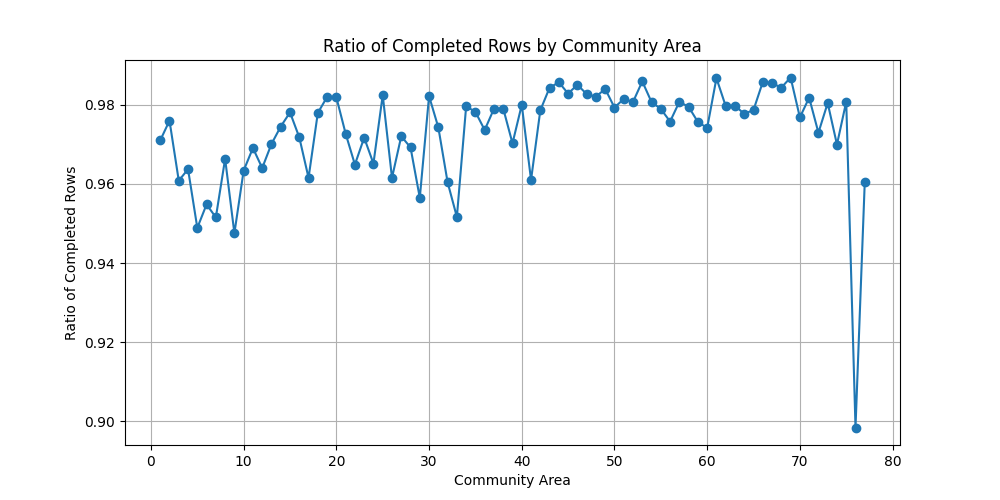

In [36]:
import matplotlib.pyplot as plt

# Sort the DataFrame based on 'community area'
agg_pd_df = agg_pd_df.sort_values(by='community_area')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(agg_pd_df['community_area'], agg_pd_df['Ratio'], marker='o')
plt.xlabel('Community Area')
plt.ylabel('Ratio of Completed Rows')
plt.title('Ratio of Completed Rows by Community Area')
plt.grid(True)
plt.show()
%matplot plt

The distribution appears to be largely uniform, fluctuating around a 96% completion rate for the majority of entries. Therefore, it is justifiable to proceed solely with the DataFrame containing fully populated rows.

In [37]:
df = df_no_missing

#### Removing duplicates

In [38]:
count_by_case_number = df.groupBy("case_number").agg(F.count("*").alias("count"))
count_by_case_number_filtered = count_by_case_number.filter(F.col("count") > 1).orderBy("count", ascending=False)
count_by_case_number_filtered.show()

df = df.dropDuplicates(subset=["case_number"])

count_by_case_number = df.groupBy("case_number").agg(F.count("*").alias("count"))
count_by_case_number_filtered = count_by_case_number.filter(F.col("count") > 1).orderBy("count", ascending=False)
count_by_case_number_filtered.show()

+-----------+-----+
|case_number|count|
+-----------+-----+
|   JE266473|    5|
|   JD286197|    4|
|   JF445443|    3|
|   JD272406|    3|
|   JD448026|    3|
|   JF356096|    3|
|   JF505994|    3|
|   JF198311|    3|
|   JD303327|    3|
|   JD298408|    2|
|   JE238268|    2|
|   JF394963|    2|
|   JD248739|    2|
|   JE104664|    2|
|   JE290325|    2|
|   JF487748|    2|
|   JD243541|    2|
|   JF510925|    2|
|   JF225079|    2|
|   JF482140|    2|
+-----------+-----+
only showing top 20 rows

+-----------+-----+
|case_number|count|
+-----------+-----+
+-----------+-----+


In [39]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: double (nullable = true)
 |-- community_area: double (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)


#### Example: Write the data in the DynamicFrame to a location in Amazon S3 and a table for it in the AWS Glue Data Catalog


In [40]:
df.show()

+--------+-----------+-------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+
|      id|case_number|               date|               block|iucr|     primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|
+--------+-----------+-------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+
|   25181|   HM711700|2020-03-18 12:19:00|  001XX N KEDZIE AVE|0110|         HOMICIDE| FIRST DEGREE MURDER|         PARKING LOT| false|   f

#### Write the cleaned dataset to S3 in parquet format

In [42]:
from awsglue.dynamicframe import DynamicFrame

dyf = DynamicFrame.fromDF(df, glueContext, "chicago_crime_cleaned_dynamic_frame")

dyf.printSchema()

s3output = glueContext.getSink(
  path="s3://chicagocrimedata-chalenge/data/chicago_crime_cleaned_database",
  connection_type="s3",
  updateBehavior="UPDATE_IN_DATABASE",
  partitionKeys=[],
  compression="snappy",
  enableUpdateCatalog=True,
  transformation_ctx="s3output",
)
s3output.setCatalogInfo(
  catalogDatabase="chicago_crime_cleanet_parquet_database", catalogTableName="chicago_crime_cleaned_parquet"
)
s3output.setFormat("glueparquet")
s3output.writeFrame(dyf)

root
|-- id: long
|-- case_number: string
|-- date: timestamp
|-- block: string
|-- iucr: string
|-- primary_type: string
|-- description: string
|-- location_description: string
|-- arrest: boolean
|-- domestic: boolean
|-- beat: long
|-- district: long
|-- ward: double
|-- community_area: double
|-- fbi_code: string
|-- x_coordinate: double
|-- y_coordinate: double
|-- year: long
|-- updated_on: timestamp
|-- latitude: double
|-- longitude: double
|-- location: string

